In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [16]:
#数据预处理
transform = transforms.Compose([
    transforms.Grayscale(),  # 确保图像是灰度图
    transforms.Resize((28, 28)),  # 调整到28x28
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=10),  # 随机旋转
    transforms.Normalize((0.1307,), (0.3081,))
])

#加载MNIST数据集
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, 
                                         transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, 
                                        transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [17]:
#CNN模型（与之前相同）
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
#初始化模型、损失函数和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DigitCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)
model = DigitCNN().to(device)
model.load_state_dict(torch.load('digit_cnn.pth', map_location=device))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18916\3237241755.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('digit_cnn.pth', ma

<All keys matched successfully>

In [18]:
# 测试模型（测试集）
def test_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# 训练模型并保存
def train_model(num_epochs=5, save_path='digit_cnn.pth'):
    model.train()
    best_accuracy = 98.86
    best_model_state = None
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # 计算当前epoch的准确率
        current_accuracy = test_model()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        print(f'Accuracy after epoch {epoch+1}: {current_accuracy:.2f}%')
        
        # 保存最佳模型
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_model_state = model.state_dict().copy()
            torch.save(best_model_state, save_path)
            print(f'New best model saved with accuracy: {best_accuracy:.2f}%')
        
        running_loss = 0.0
    
    # 加载最佳模型
    model.load_state_dict(best_model_state)
    print(f'Best model loaded with accuracy: {best_accuracy:.2f}%')


In [ ]:
print("Training started...")
train_model(num_epochs=5, save_path='digit_cnn.pth')
print("\nTesting started...")
test_model()



正在生成混淆矩阵...


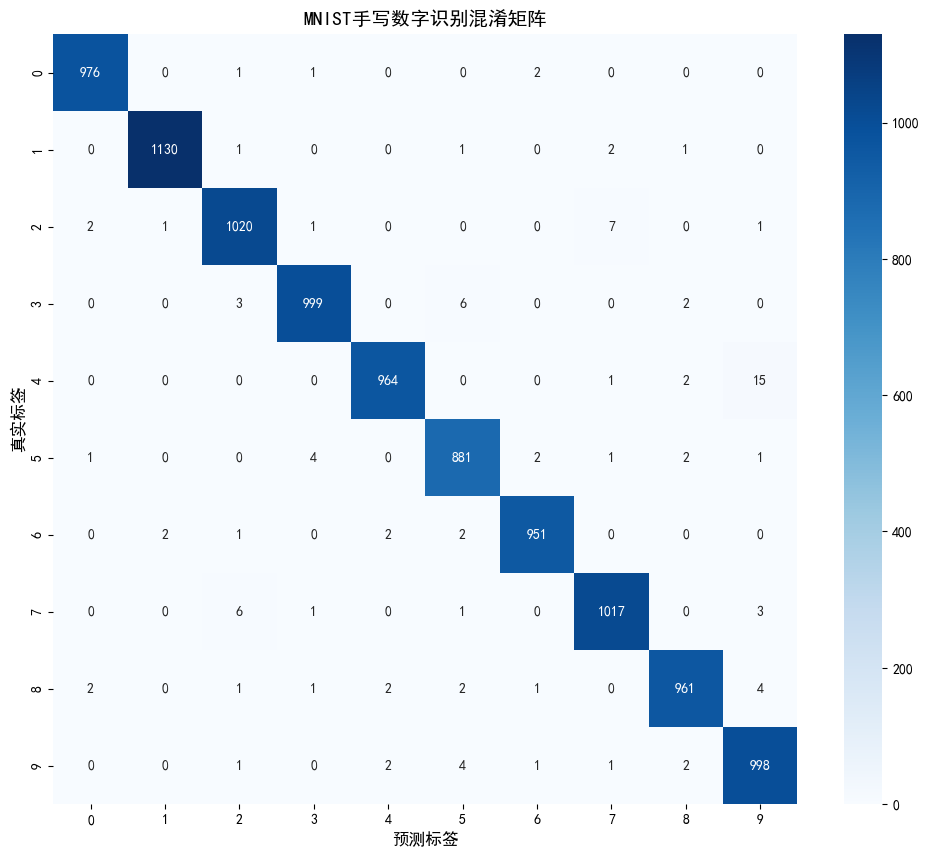

In [19]:
def calculate_confusion_matrix(num_classes=10):
    model.eval()
    # 创建混淆矩阵
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # 更新混淆矩阵
            for t, p in zip(labels.cpu().view(-1), predicted.cpu().view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
                
    return confusion_matrix

def plot_confusion_matrix():
    # 计算混淆矩阵
    cm = calculate_confusion_matrix()
    
    # 设置中文显示
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 绘制混淆矩阵
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
    plt.title('MNIST手写数字识别混淆矩阵', fontsize=14)
    plt.xlabel('预测标签', fontsize=12)
    plt.ylabel('真实标签', fontsize=12)
    
    # 设置刻度标签
    ticks = np.arange(10)
    plt.xticks(ticks + 0.5, ticks)
    plt.yticks(ticks + 0.5, ticks)
    
    plt.show()

# 执行混淆矩阵分析
print("正在生成混淆矩阵...")
plot_confusion_matrix()